# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

Observations/Analysis:

1) Obviously the only variable that is decently correlated with latitude is maximum temperature: as cities move away from the equator their maximum temperatures decrease. No other variable was correlated strongly enough with latitude to suggest a meaningful relationship. Temperature is not simply determined by solar radiation and angles, but it can be inferred that it is much less complex than how humidity, cloud cover, and wind speed are determined.

2) Interestingly, for every failed correlation, it was much weaker in the northern hemisphere than in the southern hemisphere. Even though there was no correlation between latitude and humidity/cloudiness/wind speed in either hemisphere, it was noticeably "stronger" in the south. The southern hemisphere has much less land than the northern hemisphere, and while this no doubt affects the climate in myriad ways, the explanation might be simpler. There is less land, therefore fewer cities, therefore less data, therefore any regression will inherently be stronger because it is a smaller sample.

3) There are some minor things that are noticeable, even if other plots weren't correlated. For example, when it comes to humidity and latitude, in both the nothern and southern hemispheres, cities appear (but it's not suggested by regression) to have a lower humidity around |30| degrees. This tracks with the fact that this is typically where most of the Earth's deserts appear, thanks to being on convergent zones between the Ferrell and Hadley Cells. But for the other two variables, no clear patterns (even if weak) are discernable.


In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [4]:
# List for holding lat_lngs and cities and countries
lat_lngs = []
cities = []
countries = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination, and the country code for that same lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    # If the city is unique, then add it to a our cities list
    # add the country code (made uppercase) into the countries list
    if city not in cities:
        cities.append(city)
        countries.append(country.upper())

# Print the city count to confirm sufficient count
len(cities)

601

In [5]:
# create a dataframe with empty columns of all the data we'll want
weather_df = pd.DataFrame({"City": cities, "Lat": "", "Lng": "", "Max Temp": "", 
                          "Humidity": "", "Cloudiness": "", "Wind Speed": "",
                          "Country": countries, "Date": ""})
weather_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,trofors,,,,,,,NO,
1,albany,,,,,,,AU,
2,la ronge,,,,,,,CA,
3,bredasdorp,,,,,,,ZA,
4,punta arenas,,,,,,,CL,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
#base url
url = "http://api.openweathermap.org/data/2.5/weather?"
blurb = "-"*29

#counters
recordnum = 1
setnum = 1

print(f"Beginning Data Retrieval")
print(f"{blurb}")

#iterate through the dataframe, for each index/row, take the city and country to form the query
#use them along with the api key and making sure the units are in imperial
for index, row in weather_df.iterrows():
    query = url + "appid=" + weather_api_key + "&q=" + row["City"] + "," + row["Country"] + "&units=imperial"
    #create a response using requests.get (and make sure it is converted into json)
    response = requests.get(query).json()
    
    #for each api call, attempt to retrieve the coordinates, temperature, humidity, etc
    try:
        print(f"Processing Record {recordnum} of Set {setnum} | {response['name']}")
        
        weather_df.loc[index, "Lat"] = response["coord"]["lat"]
        weather_df.loc[index, "Lng"] = response["coord"]["lon"]
        weather_df.loc[index, "Max Temp"] = response["main"]["temp_max"]
        weather_df.loc[index, "Humidity"] = response["main"]["humidity"]
        weather_df.loc[index, "Cloudiness"] = response["clouds"]["all"]
        weather_df.loc[index, "Wind Speed"] = response["wind"]["speed"]
        weather_df.loc[index, "Date"] = response["dt"]
        
        #increment the counter
        recordnum += 1
    
    #if the city is not in the database, or if the data cannot be found, except
    except (KeyError, IndexError):
        print(f"City not found. Skipping...")
    
    #conditions for the counters, so that no more than 50 cities can be in each set
    if recordnum == 51:
        setnum += 1
        recordnum = 1

print(f"{blurb}")
print(f"Data Retrieval Complete")
print(f"{blurb}")

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | Trofors
Processing Record 2 of Set 1 | Albany
Processing Record 3 of Set 1 | La Ronge
Processing Record 4 of Set 1 | Bredasdorp
Processing Record 5 of Set 1 | Punta Arenas
Processing Record 6 of Set 1 | Yellowknife
Processing Record 7 of Set 1 | Meulaboh
Processing Record 8 of Set 1 | Jacareacanga
Processing Record 9 of Set 1 | Saint-Philippe
City not found. Skipping...
Processing Record 10 of Set 1 | Roebourne
City not found. Skipping...
Processing Record 11 of Set 1 | Aksarka
Processing Record 12 of Set 1 | Jieshi
Processing Record 13 of Set 1 | Mayumba
Processing Record 14 of Set 1 | Rikitea
Processing Record 15 of Set 1 | Terdāl
Processing Record 16 of Set 1 | Ilulissat
Processing Record 17 of Set 1 | Saratovskaya
Processing Record 18 of Set 1 | Talnakh
Processing Record 19 of Set 1 | Oban
Processing Record 20 of Set 1 | Tuktoyaktuk
Processing Record 21 of Set 1 | Lüderitz
Processing Record 22 of 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
#clean up the dataframe by dropping any rows that are missing data
weather_df["Lat"] = weather_df["Lat"].replace("", np.nan)
weather_df = weather_df.dropna(how="any")
#name the index column and save the dataframe as a csv file
weather_df.index.name = "City_ID"
weather_df.to_csv("../Output/WeatherDatabyCity.csv")
#make sure no more data is missing
weather_df.count()

City          549
Lat           549
Lng           549
Max Temp      549
Humidity      549
Cloudiness    549
Wind Speed    549
Country       549
Date          549
dtype: int64

In [8]:
weather_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,trofors,65.53,13.41,55.4,76,75,4.7,NO,1595255907
1,albany,-35.02,117.89,50,81,90,6.93,AU,1595255907
2,la ronge,55.10,-105.28,62.6,88,75,3.36,CA,1595255907
3,bredasdorp,-34.53,20.04,64.4,72,40,5.82,ZA,1595255907
4,punta arenas,-53.15,-70.92,30.2,92,75,2.24,CL,1595255907


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [9]:
#there are no cities with a humidity above 100
#still convert the object data of these columns into numeric
weather_df["Lat"] = weather_df["Lat"].apply(pd.to_numeric, errors="coerce")
weather_df["Lng"] = weather_df["Lng"].apply(pd.to_numeric, errors="coerce")
weather_df["Max Temp"] = weather_df["Max Temp"].apply(pd.to_numeric, errors="coerce")
weather_df["Humidity"] = weather_df["Humidity"].apply(pd.to_numeric, errors="coerce")
weather_df["Cloudiness"] = weather_df["Cloudiness"].apply(pd.to_numeric, errors="coerce")
weather_df["Wind Speed"] = weather_df["Wind Speed"].apply(pd.to_numeric, errors="coerce")
weather_df["Date"] = weather_df["Date"].apply(pd.to_numeric, errors="coerce")

#so that we can check the max value of the humidity column
weather_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,5.490000e+02
mean,20.452732,17.319927,70.546066,68.052823,52.744991,7.235464,1.595256e+09
std,34.268348,92.603592,14.713074,22.693912,37.919534,4.819246,5.961953e+01
min,-54.800000,-179.170000,26.600000,1.000000,0.000000,0.360000,1.595256e+09
25%,-7.930000,-65.100000,59.000000,57.000000,15.000000,3.360000,1.595256e+09
50%,22.950000,23.370000,71.870000,72.000000,64.000000,6.620000,1.595256e+09
75%,50.700000,100.180000,81.230000,85.000000,90.000000,10.000000,1.595256e+09
max,78.220000,179.320000,113.850000,100.000000,100.000000,25.280000,1.595256e+09


In [10]:
#  Get the indices of cities that have humidity over 100%.
index_label = weather_df[weather_df["Humidity"] > 100].index.tolist()
index_label

[]

In [11]:
# Make a new dataframe and drop all humidity outliers (if there are any) by index
city_data = weather_df

for x in index_label:
    city_data.drop(x)

#save the new (and functionally identical) dataframe to a csv file
city_data.to_csv("../Output/city_data.csv")
city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,trofors,65.53,13.41,55.4,76,75,4.70,NO,1595255907
1,albany,-35.02,117.89,50.0,81,90,6.93,AU,1595255907
2,la ronge,55.10,-105.28,62.6,88,75,3.36,CA,1595255907
3,bredasdorp,-34.53,20.04,64.4,72,40,5.82,ZA,1595255907
4,punta arenas,-53.15,-70.92,30.2,92,75,2.24,CL,1595255907


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

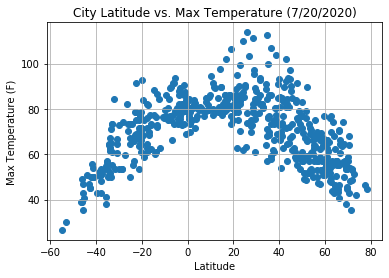

In [12]:
#use matplotlib to create scatter plots, the code is basically the same each time, only the variables change
#facecolor="4C92C3"
plt.scatter(city_data["Lat"], city_data["Max Temp"], marker="o")

#make sure to create a title, and label the axes, and create a grid
plt.title(f"City Latitude vs. Max Temperature (7/20/2020)")
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.grid(True)

#save the scatter plot as an image
plt.savefig("../Output/Lat_vs_Temp.png")
#repeat this process for the next 4 scatter plots

A scatter plot, using matplotlib, testing the correlation between a city's latitude and its maximum temperature (F)
Shows that cities closer to the equator do tend to have a higher maxmimum temperature

## Latitude vs. Humidity Plot

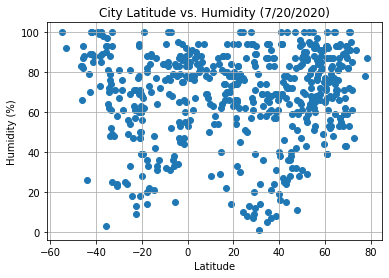

In [13]:
plt.scatter(city_data["Lat"], city_data["Humidity"], marker="o")

plt.title(f"City Latitude vs. Humidity (7/20/2020)")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

plt.savefig("../Output/Lat_vs_Humid.png")

A scatter plot, using matplotlib, testing the correlation between a city's latitude and its humidity
Does not show a clear correlation between a city's latitude and its humidity
Although there is a slight shape that suggests that cities around 30-50 N and (slightly less so for S) have lower humidities than other cities
This is generally where the deserts of Earth exist (and deserts are bigger in the Northern Hemisphere, which explains the uneven distribution of this particular phenomenon between hemispheres)

## Latitude vs. Cloudiness Plot

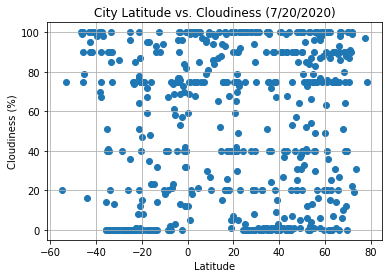

In [14]:
plt.scatter(city_data["Lat"], city_data["Cloudiness"], marker="o")

plt.title(f"City Latitude vs. Cloudiness (7/20/2020)")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)

plt.savefig("../Output/Lat_vs_Cloud.png")

A scatter plot, using matplotlib, testing the correlation between a city's latitude and its cloud cover percentage
Despite there being a clear shape, its difficult to determine what it suggests, as otherwise it appears totally random how much cloud cover a city will get depending on its latitude

## Latitude vs. Wind Speed Plot

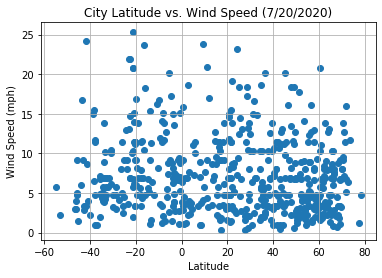

In [15]:
plt.scatter(city_data["Lat"], city_data["Wind Speed"], marker="o")

plt.title(f"City Latitude vs. Wind Speed (7/20/2020)")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

plt.savefig("../Output/Lat_vs_Wind.png")

A scatter plot, using matplotlib, testing the correlation between a city's latitude and its wind speed (mph)
Does not show a strong correlation, small suggestion that cities closer to the equator might have slightly higher windspeeds, which can be explained by the Corriolis Effect, but other factors (such as ocean currents, landmass, and if a city is on an island) have to be taken into consideration

## Linear Regression

In [16]:
# OPTIONAL: Create a function to create Linear Regression plots
# using linregress and scipy.stats 
# determine the correlation coefficient using pearsonr, and use that to get the r-squared value
# use the linregress variables to create an equation for the regression line
# display both the r squared value and the regression line equation
# plot the regression line onto the scatter plot that calls this function
def regress(x,y):
    import scipy.stats as st
    corr = st.pearsonr(x, y)
    corr1 = corr[0]
    rsquare = round(corr1**2,6)
    print(f"The r-squared is: {rsquare}")
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.plot(x,regress_values,"r-")
    print(f"The regression line is: {line_eq}")

In [17]:
# Create Northern and Southern Hemisphere DataFrames
# search only for northern hemisphere cities, and then only southern hemisphere cities
# both include the equator
northern_df = city_data.loc[(city_data["Lat"] >= 0)]
southern_df = city_data.loc[(city_data["Lat"] <= 0)]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.466983
The regression line is: y = -0.5x + 92.09


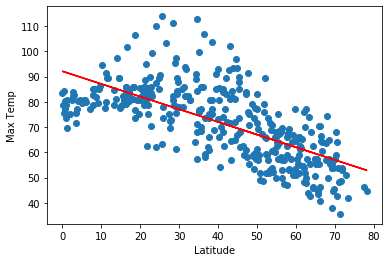

In [18]:
# create a scatter plot using the relevant columns from the data frames, and labeling the axes
lat = northern_df["Lat"]
temp = northern_df["Max Temp"]

plt.scatter(lat, temp, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Max Temp")

# call the regress function to output the numbers we want and to plot the regression line
regress(lat,temp)
# the rest of the regression lines will use the same basic code template

Using a python function to run a linear regression analysis on the scatter plot for Northern Hemisphere cities against their maximum temperatures
The line shows a moderate correlation: as cities appear farther north their maximum temperature decreases 

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.678641
The regression line is: y = 0.85x + 86.19


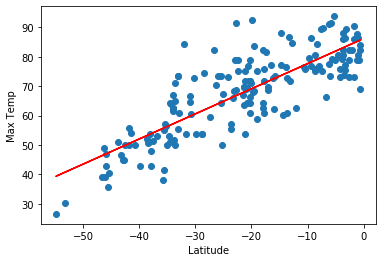

In [19]:
lat = southern_df["Lat"]
temp = southern_df["Max Temp"]

plt.scatter(lat, temp, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Max Temp")

regress(lat,temp)

Using a python function to run a linear regression analysis on the scatter plot for Southern Hemisphere cities against their maximum temperatures
The line shows a moderate correlation: as cities appear farther south their maximum temperature decreases

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.005305
The regression line is: y = 0.08x + 65.68


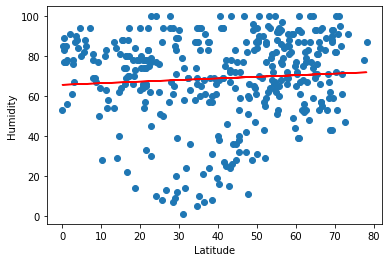

In [20]:
lat = northern_df["Lat"]
hum = northern_df["Humidity"]

plt.scatter(lat, hum, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

regress(lat,hum)

Using a python function to run a linear regression analysis on the scatter plot for Nothern Hemisphere cities against their humidity
The line shows practically no correlation, humidity cannot be predicted just by changing temperatures along latitudes, it appears to be a more complex phenomenon   

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.029349
The regression line is: y = -0.3x + 59.85


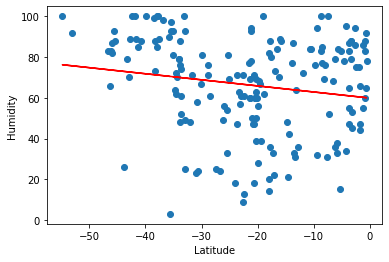

In [21]:
lat = southern_df["Lat"]
hum = southern_df["Humidity"]

plt.scatter(lat, hum, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

regress(lat,hum)

Using a python function to run a linear regression analysis on the scatter plot for Southern Hemisphere cities against their humidity
The line shows a very slightly stronger correlation than its northern counterpart, but still not enough to suggest any kind of meaningful relationship between humidity and latitude

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.000962
The regression line is: y = -0.06x + 57.29


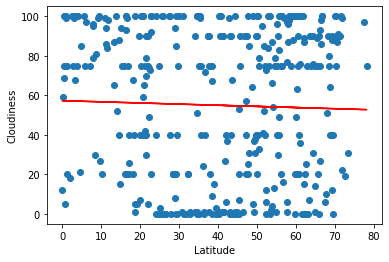

In [22]:
lat = northern_df["Lat"]
cloud = northern_df["Cloudiness"]

plt.scatter(lat, cloud, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

regress(lat,cloud)

Using a python function to run a linear regression analysis on the scatter plot for Northern Hemisphere cities against their cloud cover percentage
The line shows absolutely no correlation at all, clouds are not dependent on latitude to form

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.010098
The regression line is: y = -0.28x + 42.08


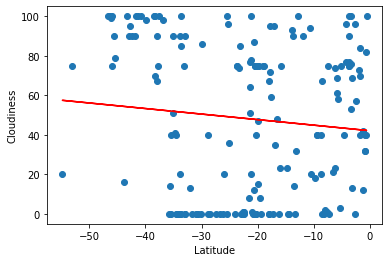

In [23]:
lat = southern_df["Lat"]
cloud = southern_df["Cloudiness"]

plt.scatter(lat, cloud, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

regress(lat,cloud)

Using a python function to run a linear regression analysis on the scatter plot for Southern Hemisphere cities against their cloud cover percentage
The line again (coincidentally) shows a slightly stronger correlation than its northern counterpart, but it still does not suggest any kind of relationship 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.007185
The regression line is: y = -0.02x + 7.62


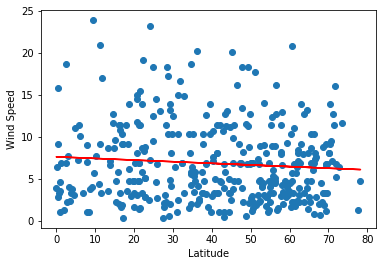

In [24]:
lat = northern_df["Lat"]
wind = northern_df["Wind Speed"]

plt.scatter(lat, wind, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")

regress(lat,wind)

Using a python function to run a linear regression analysis on the scatter plot for Northern Hemisphere cities against their wind speed
The line shows no correlation between latitude and wind speed  

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.014107
The regression line is: y = 0.04x + 9.03


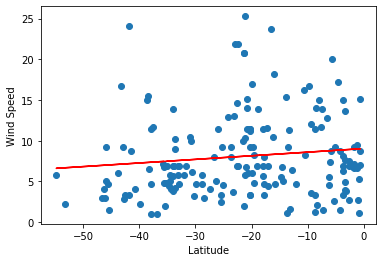

In [25]:
lat = southern_df["Lat"]
wind = southern_df["Wind Speed"]

plt.scatter(lat, wind, marker="o")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")

regress(lat,wind)

Using a python function to run a linear regression analysis on the scatter plot for Southern Hemisphere cities against their wind speed
The line shows no correlation between latitude and wind speed, but it is stronger than the nothern one